In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nitishabharathi/cert-insider-threat")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pc\.cache\kagglehub\datasets\nitishabharathi\cert-insider-threat\versions\1


In [3]:
files = os.listdir(path)
print("Dataset Files:", files)
df = pd.read_csv(os.path.join(path, "email.csv"))
# Map Threat column to numerical (Yes -> 1, No -> 0)
df["Threat"] = np.random.choice(["Yes", "No"], size=len(df), p=[0.5, 0.5])
df["Threat"] = df["Threat"].map({"Yes": 1, "No": 0})
df = df.sample(n=500, random_state=42)
# Display first few rows
print(df.head(5))


Dataset Files: ['email.csv', 'psychometric.csv']
                               id                 date     user       pc  \
1375085  {X9O7-L3NQ83SH-7546ROCM}  09/08/2010 09:48:21  HWH0646  PC-8087   
1760687  {N4J5-H0DM81GR-0636AXZX}  11/18/2010 11:40:48  EMW0772  PC-6035   
489761   {T3T3-X0QU63SN-9148FQEX}  03/29/2010 14:40:35  HAD0246  PC-0926   
670295   {S1I7-L4JZ84KI-7061AWTL}  04/30/2010 10:57:44  ASB0796  PC-1130   
2611719  {C8B5-Q0BW49BI-1420XVWZ}  05/12/2011 11:45:23  HCW0419  PC-3772   

                                                        to   cc  \
1375085  Ursa.Britanney.Frederick@dtaa.com;Abel.Adam.Mo...  NaN   
1760687  Butler-Serina@yahoo.com;Vance-Quintessa@netzer...  NaN   
489761                                  TEB582@verizon.net  NaN   
670295   Tobias.Lucas.Morin@dtaa.com;Sonya.Samantha.Hah...  NaN   
2611719                         Herman.Ian.Abbott@dtaa.com  NaN   

                                  bcc                                from  \
1375085       

In [4]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [5]:
# Extract features & target
X = df.drop(columns=['Threat'])
y = df['Threat']

# Ensure all features are numerical before transformations
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)


In [6]:
# Preprocessing techniques to test
preprocessing_methods = {
    "Baseline": lambda X, y: (X, y),
    "One-Hot Encoding": lambda X, y: (np.hstack((OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit_transform(X[categorical_cols]), X.drop(columns=categorical_cols).values)), y),
    "Standardization": lambda X, y: (StandardScaler().fit_transform(X), y),
    "PCA": lambda X, y: (PCA(n_components=0.95).fit_transform(StandardScaler().fit_transform(X)), y),
    "SMOTE": lambda X, y: SMOTE(random_state=42).fit_resample(X, y)
}

accuracy_results = {}

In [7]:
for method, preprocess in preprocessing_methods.items():
    print(f"Applying {method}...")
    X_processed, y_processed = preprocess(X, y)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)
    
    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = knn.predict(X_test)
    
    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[method] = accuracy
    print(f"{method} Test Accuracy: {accuracy:.4f}")

Applying Baseline...
Baseline Test Accuracy: 0.5400
Applying One-Hot Encoding...
One-Hot Encoding Test Accuracy: 0.4900
Applying Standardization...
Standardization Test Accuracy: 0.4900
Applying PCA...
PCA Test Accuracy: 0.4900
Applying SMOTE...
SMOTE Test Accuracy: 0.5400


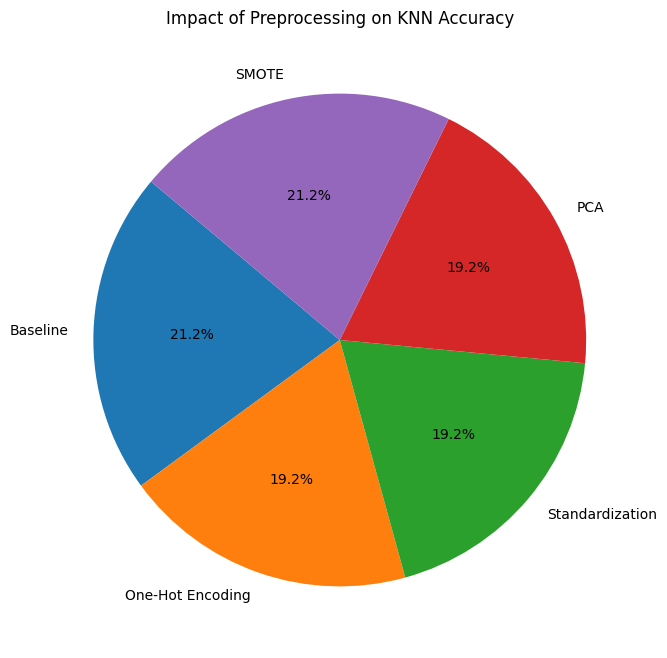

In [8]:
# Plot results in a pie chart
plt.figure(figsize=(8, 8))
plt.pie(accuracy_results.values(), labels=accuracy_results.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Impact of Preprocessing on KNN Accuracy")
plt.show()
